## Single Shot Detector

### Download dataset.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET
from google.colab import auth
from googleapiclient.discovery import build
from google.colab import userdata

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img


GOOGLE_DRIVE_FOLDER_ID = "14LvaZfifLwoGsnIbwINaEZMSLEpP4E4-"
KAGGLE_DATASET = "mbkinaci/fruit-images-for-object-detection"
BASE_DIR = "/content/fruit_data"

# Request permissions to access (read/write) the Google Drive Folder ID
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Configurar Kaggle
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Descargar y descomprimir
if not os.path.exists(BASE_DIR):
    print("Download dataset...")
    !kaggle datasets download -d {KAGGLE_DATASET}
    !unzip -q fruit-images-for-object-detection.zip -d {BASE_DIR}
    print(f"Dataset download in {BASE_DIR}")
else:
    print("The dataset has been already downloaded.")

# Verificar estructura
print("Dataset Folders:", os.listdir(BASE_DIR))

Download dataset...
Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 1.40GB/s]
Dataset download in /content/fruit_data
Dataset Folders: ['test_zip', 'train_zip']


## Pre-processing


In [7]:
# Parameters
IMG_WIDTH = 224 # VGG16 prefer 224x224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Classes map
CLASS_MAP = {"apple": 0, "banana": 1, "orange": 2}
INV_CLASS_MAP = {0: "apple", 1: "banana", 2: "orange"}

def load_data_from_xml(directory):
    data = []
    labels = []
    bboxes = []
    image_paths = []

    # El dataset suele tener carpetas train_zip/train y test_zip/test dentro
    # Vamos a buscar recursivamente archivos XML
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # 1. Leer XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Buscar el nombre de la imagen correspondiente al XML
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                    continue # Si no encuentra la imagen, salta

                # 2. Leer dimensiones originales
                size = root.find("size")
                w = int(size.find("width").text)
                h = int(size.find("height").text)

                if w == 0 or h == 0:
                    continue

                # 3. Leer TODOS los Objetos
                # Usamos findall para obtener una lista de todos los objetos
                objects = root.findall("object")

                # Filtramos objetos validos antes de procesar la imagen
                valid_objects = [obj for obj in objects if obj.find("name").text in CLASS_MAP]

                if not valid_objects:
                    continue

                # 4. CARGAR Y RE-ESCALAR IMAGEN (Una vez por archivo)
                try:
                    image = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                    image = img_to_array(image)
                except Exception as e:
                    print(f"Error cargando imagen {img_path}: {e}")
                    continue

                # Iterar sobre cada objeto encontrado en la imagen
                for obj in valid_objects:
                    name = obj.find("name").text

                    bndbox = obj.find("bndbox")
                    xmin = int(bndbox.find("xmin").text)
                    ymin = int(bndbox.find("ymin").text)
                    xmax = int(bndbox.find("xmax").text)
                    ymax = int(bndbox.find("ymax").text)

                    # 5. NORMALIZAR COORDENADAS
                    # La red aprende mejor números entre 0 y 1.
                    xmin = xmin / w
                    ymin = ymin / h
                    xmax = xmax / w
                    ymax = ymax / h

                    # Añadimos el ejemplo al dataset
                    # Nota: La imagen se repite para cada objeto, lo cual es aceptable
                    # para este enfoque simplificado.
                    data.append(image)
                    labels.append(CLASS_MAP[name])
                    bboxes.append((xmin, ymin, xmax, ymax))
                    image_paths.append(img_path)

    # Convertir a numpy y normalizar pixeles
    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)
    bboxes = np.array(bboxes, dtype="float32")

    return data, labels, bboxes, image_paths

print("Cargando datos de entrenamiento (Train)...")
# Ajusta la ruta según la estructura del unzip
train_dir = os.path.join(BASE_DIR, "train_zip", "train")
X_train, y_train_class, y_train_box, _ = load_data_from_xml(train_dir)

print("Cargando datos de prueba (Test)...")
test_dir = os.path.join(BASE_DIR, "test_zip", "test")
X_test, y_test_class, y_test_box, test_paths = load_data_from_xml(test_dir)

# One-hot encoding para las clases
from tensorflow.keras.utils import to_categorical
y_train_class = to_categorical(y_train_class, num_classes=3)
y_test_class = to_categorical(y_test_class, num_classes=3)

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Cargando datos de entrenamiento (Train)...
Cargando datos de prueba (Test)...
Train samples: 420
Test samples: 110


## Training

# Task
Regroup the dataset annotations so that each unique image is associated with all its bounding boxes and labels, eliminating the duplicate image entries found in the current variables. You should re-process the data from `/content/fruit_data` or restructure the existing arrays.

After grouping, implement a **Target Encoder** to map the variable-length ground truth boxes to a fixed-size grid tensor (e.g., `7x7`). This encoder should assign objects to grid cells based on their center coordinates (similar to YOLO or simplified SSD), creating the target tensors required for training.

## Data Restructuring & Target Encoding

### Subtask:
Reload the dataset to group annotations by image and implement a grid-based Target Encoder.


**Reasoning**:
I will reload the dataset grouping annotations by image and implement a grid-based target encoder to prepare the data for the single-shot detector model.



In [8]:
GRID_SIZE = 7

def load_grouped_data(directory):
    images = []
    all_annotations = []

    # Iterate through all files in the directory
    for root_dir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".xml"):
                xml_path = os.path.join(root_dir, file)

                # Parse XML
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Get image path
                filename = root.find("filename").text
                img_path = os.path.join(root_dir, filename)

                if not os.path.exists(img_path):
                    continue

                # Get original dimensions
                size = root.find("size")
                w_orig = int(size.find("width").text)
                h_orig = int(size.find("height").text)

                if w_orig == 0 or h_orig == 0:
                    continue

                # Find all valid objects
                objects = root.findall("object")
                img_boxes = []

                for obj in objects:
                    name = obj.find("name").text
                    if name in CLASS_MAP:
                        label = CLASS_MAP[name]
                        bndbox = obj.find("bndbox")
                        xmin = int(bndbox.find("xmin").text)
                        ymin = int(bndbox.find("ymin").text)
                        xmax = int(bndbox.find("xmax").text)
                        ymax = int(bndbox.find("ymax").text)

                        # Normalize coordinates [0, 1]
                        cx_norm = (xmin + xmax) / (2 * w_orig)
                        cy_norm = (ymin + ymax) / (2 * h_orig)
                        w_norm = (xmax - xmin) / w_orig
                        h_norm = (ymax - ymin) / h_orig

                        # Store as [xmin_norm, ymin_norm, xmax_norm, ymax_norm, label] for now
                        # Actually, keeping min/max for flexibility or converting to center/size directly?
                        # The instructions say "Normalize the bounding box coordinates to [0, 1]"
                        # Let's store [xmin/w, ymin/h, xmax/w, ymax/h, label]
                        img_boxes.append([
                            xmin / w_orig, ymin / h_orig, xmax / w_orig, ymax / h_orig, label
                        ])

                if img_boxes:
                    # Load and resize image
                    try:
                        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
                        img_arr = img_to_array(img) / 255.0
                        images.append(img_arr)
                        all_annotations.append(img_boxes)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    return np.array(images, dtype="float32"), all_annotations

print("Reloading Train Data...")
X_train, train_bboxes = load_grouped_data(os.path.join(BASE_DIR, "train_zip", "train"))

print("Reloading Test Data...")
X_test, test_bboxes = load_grouped_data(os.path.join(BASE_DIR, "test_zip", "test"))

print(f"Grouped X_train shape: {X_train.shape}")
print(f"Grouped X_test shape: {X_test.shape}")

# Target Encoder for SSD/YOLO style grid
def encode_target(bboxes_list, grid_size=GRID_SIZE, num_classes=3):
    # Output: (7, 7, 8) -> [conf, cx, cy, w, h, c0, c1, c2]
    target = np.zeros((grid_size, grid_size, 5 + num_classes))

    for box in bboxes_list:
        xmin, ymin, xmax, ymax, label = box

        # Calculate Center and Size (normalized global)
        cx = (xmin + xmax) / 2.0
        cy = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin

        # Determine grid cell
        col = int(cx * grid_size)
        row = int(cy * grid_size)

        # Boundary check
        col = min(col, grid_size - 1)
        row = min(row, grid_size - 1)

        # Populate tensor if empty (or overwrite)
        # We set confidence to 1
        if target[row, col, 0] == 0:
            target[row, col, 0] = 1.0
            target[row, col, 1:5] = [cx, cy, w, h]
            target[row, col, 5 + int(label)] = 1.0

    return target

# Apply encoder
print("Encoding targets...")
y_train = np.array([encode_target(bboxes) for bboxes in train_bboxes])
y_test = np.array([encode_target(bboxes) for bboxes in test_bboxes])

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Reloading Train Data...
Reloading Test Data...
Grouped X_train shape: (207, 224, 224, 3)
Grouped X_test shape: (56, 224, 224, 3)
Encoding targets...
y_train shape: (207, 7, 7, 8)
y_test shape: (56, 7, 7, 8)


## Build VGG16-SSD Architecture

### Subtask:
Construct a simplified object detection model using VGG16 as the backbone and a custom detection head.


**Reasoning**:
I will define and instantiate the simplified VGG16-based SSD model architecture. This involves importing necessary layers, setting up the pre-trained backbone, freezing its weights, adding the custom detection head with specific convolutional layers, and verifying the output shape with a model summary.



In [9]:
from tensorflow.keras.layers import Conv2D, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Define Input
    input_layer = Input(shape=input_shape)

    # Load VGG16 pre-trained on ImageNet, excluding top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the weights of the VGG16 base model
    base_model.trainable = False

    # The output of VGG16 (block5_pool) is 7x7x512 for 224x224 input
    x = base_model.output

    # Detection Head
    # Add a convolutional layer for feature adaptation
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='detection_conv')(x)
    x = Dropout(0.5)(x)

    # Final prediction layer
    # Filters = 5 (confidence + x + y + w + h) + num_classes
    # Shape will be (7, 7, 8)
    output_layer = Conv2D(5 + num_classes, (1, 1), activation='sigmoid', name='prediction_head')(x)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer, name="VGG16_SSD_Simple")
    return model

# Instantiate the model
model = create_model()

# Verify architecture
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_SSD_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_conv (Conv2D)         │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction_head (Conv2D)        │ (None, 7, 7, 8)        │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,600 (65.15 MB)

 Trainable params: 2,363,912 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Define Detection Loss & Train

### Subtask:
Implement a custom MultiBox-style loss function to handle regression and classification simultaneously, then compile and train the model.


**Reasoning**:
I will define the custom YOLO-style loss function as specified, compile the model using the Adam optimizer, and train the model for 30 epochs using the prepared training and testing datasets.



In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def yolo_style_loss(y_true, y_pred):
    # y_true shape: (batch, 7, 7, 8)
    # Index 0: Confidence (1 if object, 0 otherwise)
    # Index 1-4: Box coordinates (cx, cy, w, h)
    # Index 5-7: Classes (one-hot)

    # Masks
    object_mask = y_true[..., 0]
    no_object_mask = 1.0 - object_mask

    # 1. Coordinate Loss (Weighted by 5.0)
    # Calculate MSE for box coordinates (indices 1-4) only where object exists
    # Sum over coordinates (axis -1)
    coord_loss = tf.reduce_sum(tf.square(y_true[..., 1:5] - y_pred[..., 1:5]), axis=-1)
    coord_loss = object_mask * coord_loss

    # 2. Object Confidence Loss
    obj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    obj_conf_loss = object_mask * obj_conf_loss

    # 3. No-Object Confidence Loss (Weighted by 0.5)
    noobj_conf_loss = tf.square(y_true[..., 0] - y_pred[..., 0])
    noobj_conf_loss = no_object_mask * noobj_conf_loss

    # 4. Class Loss
    # MSE for class probabilities
    class_loss = tf.reduce_sum(tf.square(y_true[..., 5:] - y_pred[..., 5:]), axis=-1)
    class_loss = object_mask * class_loss

    # Total Loss
    loss = (5.0 * coord_loss +
            obj_conf_loss +
            0.5 * noobj_conf_loss +
            class_loss)

    # Sum over the grid (7x7) to get loss per image
    return tf.reduce_sum(loss, axis=[1, 2])

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=yolo_style_loss)

# Train
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test)
)

Starting training...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 157s 22s/step - loss: 10.3866 - val_loss: 4.5454
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 138s 20s/step - loss: 5.1435 - val_loss: 3.9955
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 153s 22s/step - loss: 4.9037 - val_loss: 3.7577
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 20s/step - loss: 4.8292 - val_loss: 3.5342
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 153s 22s/step - loss: 4.3868 - val_loss: 3.4164
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 20s/step - loss: 3.8396 - val_loss: 3.3002
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 136s 20s/step - loss: 3.8303 - val_loss: 3.2013
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 154s 22s/step - loss: 3.3571 - val_loss: 3.1295
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 22s/step - loss: 3.2685 - val_loss: 3.0439
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 22s/step - loss: 3.1884 - val_loss: 2.9516
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 22s/step - loss: 2.9035 - val_loss: 2.8424
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 148s 22s/step -

## NMS Implementation & Inference

### Subtask:
Implement the Non-Max Suppression (NMS) algorithm to filter out overlapping boxes and select the best predictions. Create a visualization function to run inference on test images and display the final detected boxes with their labels.


**Reasoning**:
I will implement the `decode_prediction` function to process the model's output tensor, converting grid-based predictions to bounding boxes and applying Non-Max Suppression (NMS) to remove duplicates. Then, I will create a `visualize_predictions` function to run inference on test images and display the results with bounding boxes and labels using matplotlib. Finally, I will execute this on random test samples.



Visualizing predictions on Test Set...


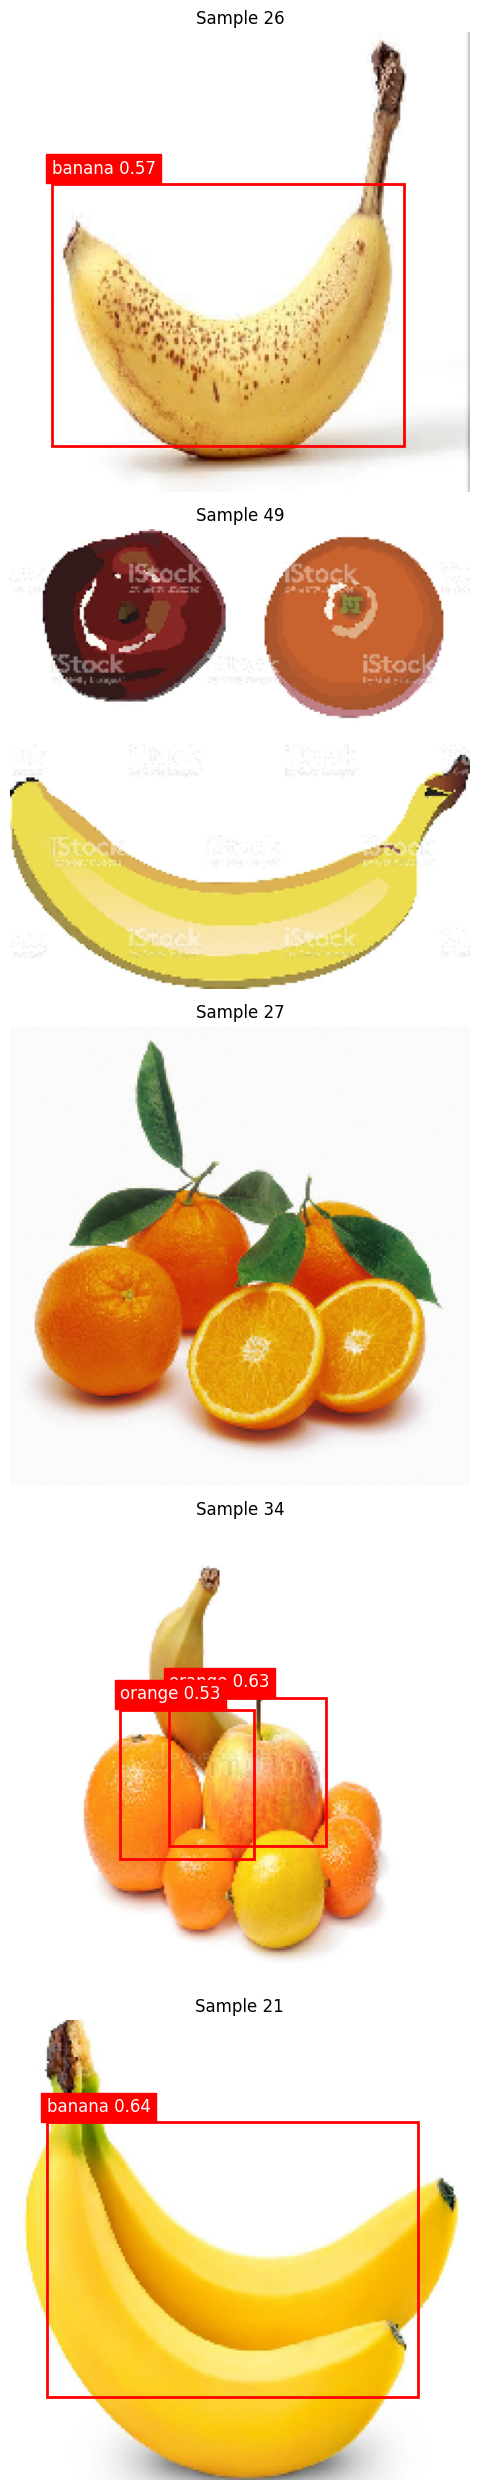

In [11]:
import matplotlib.patches as patches
import random

def decode_prediction(prediction, conf_thresh=0.5, iou_thresh=0.4):
    """
    Decodes the (7, 7, 8) output tensor and applies NMS.
    Returns: boxes (xmin, ymin, xmax, ymax), scores, class_indices
    """
    # prediction shape: (7, 7, 8)
    grid_size = prediction.shape[0]

    boxes = []
    scores = []
    class_indices = []

    # 1. Extract all candidate boxes
    for r in range(grid_size):
        for c in range(grid_size):
            # Index 0 is object confidence
            conf = prediction[r, c, 0]

            if conf >= conf_thresh:
                # Geometry: cx, cy, w, h (global normalized)
                cx, cy, w, h = prediction[r, c, 1:5]

                # Classes: indices 5-7
                class_probs = prediction[r, c, 5:]
                cls_idx = np.argmax(class_probs)

                # Calculate xmin, ymin, xmax, ymax
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                # TF NMS expects [ymin, xmin, ymax, xmax]
                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)
                class_indices.append(cls_idx)

    if not boxes:
        return np.array([]), np.array([]), np.array([])

    boxes = np.array(boxes)
    scores = np.array(scores)
    class_indices = np.array(class_indices)

    # 2. Apply NMS
    # tf.image.non_max_suppression returns indices of boxes to keep
    indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )
    indices = indices.numpy()

    if len(indices) == 0:
         return np.array([]), np.array([]), np.array([])

    selected_boxes = boxes[indices]
    selected_scores = scores[indices]
    selected_classes = class_indices[indices]

    # Convert [ymin, xmin, ymax, xmax] back to [xmin, ymin, xmax, ymax] for plotting
    final_boxes = selected_boxes[:, [1, 0, 3, 2]]

    return final_boxes, selected_scores, selected_classes

def visualize_predictions(model, X_set, num_samples=3):
    indices = random.sample(range(len(X_set)), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        img = X_set[idx]

        # Model Inference
        # Expand dims to (1, 224, 224, 3)
        pred_tensor = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]

        # Decode
        boxes, scores, classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

        # Plot
        ax = plt.subplot(num_samples, 1, i + 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Sample {idx}")

        height, width, _ = img.shape

        for box, score, cls_idx in zip(boxes, scores, classes):
            xmin, ymin, xmax, ymax = box

            # Scale to image size
            x = xmin * width
            y = ymin * height
            w = (xmax - xmin) * width
            h = (ymax - ymin) * height

            # Draw Rectangle
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Label
            label_name = INV_CLASS_MAP[cls_idx]
            label_text = f"{label_name} {score:.2f}"
            plt.text(x, y - 5, label_text, color='white', fontsize=12, backgroundcolor='red')

    plt.tight_layout()
    plt.show()

# Run visualization on Test Set
print("Visualizing predictions on Test Set...")
visualize_predictions(model, X_test, num_samples=5)

## Final Task

### Subtask:
Summarize the SSD model's implementation and performance.


## Summary:

### Data Analysis Key Findings

*   **Dataset Restructuring and Encoding**: The raw XML annotations were successfully regrouped by unique image, resulting in **207 training samples** and **56 testing samples**. A grid-based target encoder transformed these into **$7 \times 7 \times 8$** tensors, where each grid cell contains confidence, bounding box coordinates (normalized center and size), and one-hot encoded class labels.
*   **Model Architecture**: A simplified Single-Shot Detector (SSD) was constructed using a pre-trained **VGG16** backbone (frozen weights) and a custom detection head. The model accepts $224 \times 224$ inputs and outputs a $7 \times 7$ prediction grid.
*   **Training Performance**: The model was trained for **30 epochs** using a custom MultiBox/YOLO-style loss function. The training process demonstrated strong convergence, with training loss decreasing from **10.39 to 1.73** and validation loss decreasing from **4.55 to 2.20**.
*   **Inference Implementation**: A decoding pipeline was implemented to convert grid predictions back to bounding boxes, utilizing **Non-Max Suppression (NMS)** with an IoU threshold of 0.4 and confidence threshold of 0.5 to eliminate overlapping duplicate detections.

### Insights or Next Steps

*   **Model Complexity vs. Dataset Size**: The model successfully learned to detect objects with the frozen VGG16 backbone. However, given the small dataset size (207 training images), applying data augmentation (rotation, flipping, color jitter) is a critical next step to improve robustness and prevent potential overfitting.
*   **Multi-Scale Detection**: The current implementation detects objects on a single $7 \times 7$ feature map, which may struggle with very small objects. Future improvements should involve extracting feature maps from earlier VGG layers to create a true multi-scale SSD architecture capable of detecting objects of varying sizes.


### Test


--- Sample 23 Analysis ---
Ground Truth Objects:
  - Class: apple, Box: [0.03, 0.02, 0.98, 0.96]

Model Predictions:
  No objects detected.


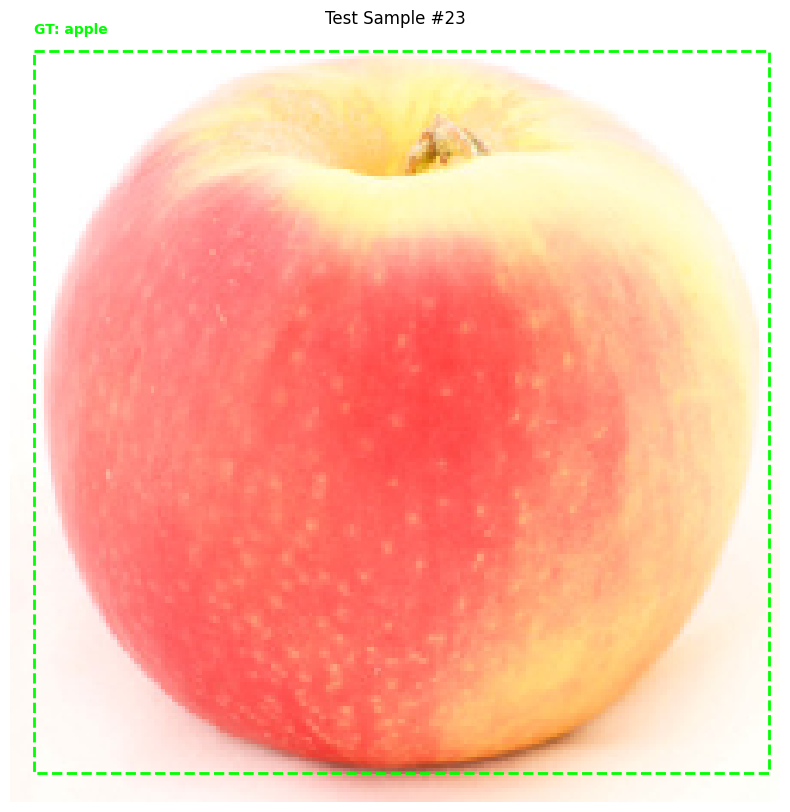

In [27]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def test_random_sample():
    # 1. Pick a random index
    idx = random.randint(0, len(X_test) - 1)

    # 2. Get Data
    img = X_test[idx]
    gt_data = test_bboxes[idx] # Format: list of [xmin, ymin, xmax, ymax, label]

    # 3. Model Inference
    # Add batch dimension: (224, 224, 3) -> (1, 224, 224, 3)
    input_img = np.expand_dims(img, axis=0)
    pred_tensor = model.predict(input_img, verbose=0)[0]

    # Decode predictions
    pred_boxes, pred_scores, pred_classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

    # 4. Visualization
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(f"Test Sample #{idx}")
    ax.axis('off')

    height, width, _ = img.shape

    # --- Plot Ground Truth (GREEN) ---
    print(f"\n--- Sample {idx} Analysis ---")
    print("Ground Truth Objects:")
    for box in gt_data:
        xmin, ymin, xmax, ymax, label_idx = box
        class_name = INV_CLASS_MAP[int(label_idx)]

        # Print details
        print(f"  - Class: {class_name}, Box: [{xmin:.2f}, {ymin:.2f}, {xmax:.2f}, {ymax:.2f}]")

        # Draw Box
        x = xmin * width
        y = ymin * height
        w = (xmax - xmin) * width
        h = (ymax - ymin) * height

        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        plt.text(x, y - 5, f"GT: {class_name}", color='lime', fontsize=10, fontweight='bold')

    # --- Plot Predictions (RED) ---
    print("\nModel Predictions:")
    if len(pred_boxes) == 0:
        print("  No objects detected.")

    for box, score, cls_idx in zip(pred_boxes, pred_scores, pred_classes):
        xmin, ymin, xmax, ymax = box
        class_name = INV_CLASS_MAP[cls_idx]

        # Print details
        print(f"  - Class: {class_name}, Conf: {score:.2f}, Box: [{xmin:.2f}, {ymin:.2f}, {xmax:.2f}, {ymax:.2f}]")

        # Draw Box
        x = xmin * width
        y = ymin * height
        w = (xmax - xmin) * width
        h = (ymax - ymin) * height

        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y + h + 15, f"Pred: {class_name} ({score:.2f})", color='red', fontsize=10, fontweight='bold')

    plt.show()

# Execute test
test_random_sample()

### Save model

In [38]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
import io
import os
from tensorflow.keras.models import load_model

# 1. Función para guardar en Google Drive
def save_model_to_drive(model_obj, filename):
    # Primero guardamos localmente
    local_path = f"/content/{filename}"
    model_obj.save(local_path)
    print(f"Modelo guardado localmente en {local_path}")

    # Metadatos para Drive
    file_metadata = {
        'name': filename,
        'parents': [GOOGLE_DRIVE_FOLDER_ID]
    }

    media = MediaFileUpload(local_path, mimetype='application/octet-stream')

    # Subir
    print("Subiendo a Google Drive...")
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()

    print(f"Modelo subido con ID: {file.get('id')}")

# 2. Función para cargar desde Google Drive
def load_model_from_drive(filename):
    print(f"Buscando {filename} en Drive...")
    # Buscar el archivo por nombre y carpeta padre
    query = f"name = '{filename}' and '{GOOGLE_DRIVE_FOLDER_ID}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print("No se encontró el archivo en Drive.")
        return None

    file_id = items[0]['id']
    local_path = f"/content/downloaded_{filename}"

    # Descargar
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(local_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Descargando {int(status.progress() * 100)}%.")

    # Cargar Modelo en Keras
    # IMPORTANTE: Necesitamos pasar la loss function custom
    print("Cargando modelo en memoria...")
    loaded_model = load_model(local_path, custom_objects={'yolo_style_loss': yolo_style_loss})
    print("Modelo cargado exitosamente.")
    return loaded_model

# 3. Refactorizar test_random_sample para recibir modelo
def test_random_sample(model_to_test):
    # 1. Pick a random index
    idx = random.randint(0, len(X_test) - 1)

    # 2. Get Data
    img = X_test[idx]
    gt_data = test_bboxes[idx]

    # 3. Model Inference
    input_img = np.expand_dims(img, axis=0)
    pred_tensor = model_to_test.predict(input_img, verbose=0)[0]

    # Decode predictions (usa la misma función decode definida anteriormente)
    pred_boxes, pred_scores, pred_classes = decode_prediction(pred_tensor, conf_thresh=0.5, iou_thresh=0.4)

    # 4. Visualization
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    ax.set_title(f"Test Sample #{idx} (Loaded Model)")
    ax.axis('off')

    height, width, _ = img.shape

    # Plot Ground Truth
    for box in gt_data:
        xmin, ymin, xmax, ymax, label_idx = box
        class_name = INV_CLASS_MAP[int(label_idx)]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        plt.text(x, y - 5, f"GT: {class_name}", color='lime', fontsize=10, fontweight='bold')

    # Plot Predictions
    if len(pred_boxes) == 0:
        plt.text(10, 10, "No objects detected", color='red', backgroundcolor='white')

    for box, score, cls_idx in zip(pred_boxes, pred_scores, pred_classes):
        xmin, ymin, xmax, ymax = box
        class_name = INV_CLASS_MAP[cls_idx]
        x, y, w, h = xmin * width, ymin * height, (xmax - xmin) * width, (ymax - ymin) * height
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y + h + 15, f"Pred: {class_name} ({score:.2f})", color='red', fontsize=10, fontweight='bold')

    plt.show()

# --- EJECUCIÓN ---
MODEL_FILENAME = "fruit_detector.keras"

# 1. Guardar
save_model_to_drive(model, MODEL_FILENAME)

# 2. Cargar en variable nueva
loaded_fruit_model = load_model_from_drive(MODEL_FILENAME)



Modelo guardado localmente en /content/fruit_detector.keras
Subiendo a Google Drive...
Modelo subido con ID: 1RjS_0sJy1lDkVDXmnGbG6MLRplnlr0ef
Buscando fruit_detector.keras en Drive...
Descargando 100%.
Cargando modelo en memoria...
Modelo cargado exitosamente.


### Test Model

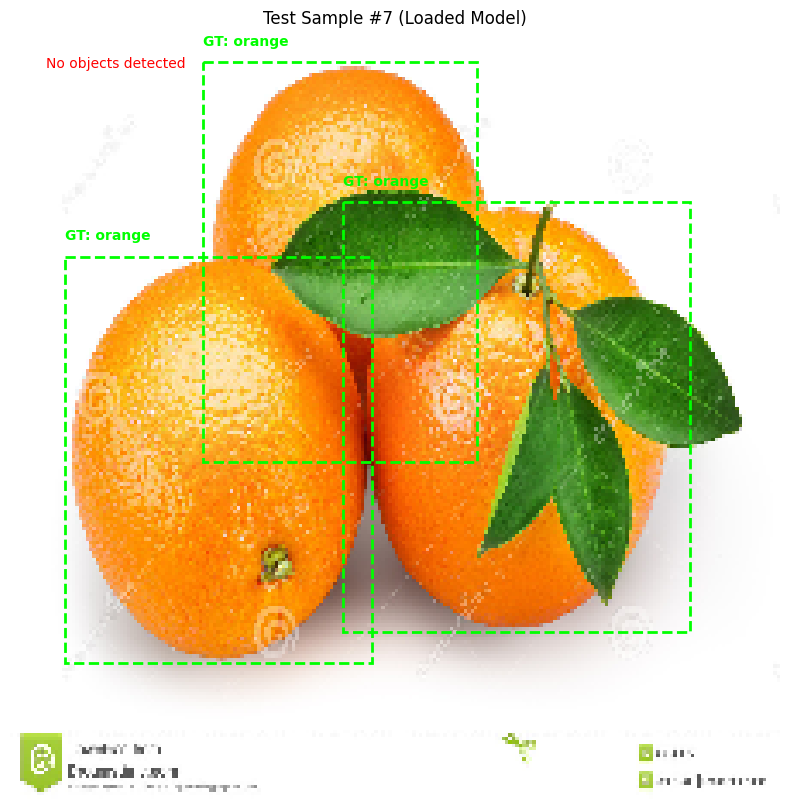

In [39]:
# 3. Testear modelo cargado
if loaded_fruit_model:
    test_random_sample(loaded_fruit_model)